In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

In [5]:
df = pd.read_csv(r"D:\ML projects\Fraud_trans_detection\Fraud.csv")

In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Cleaning and Pre-processing 

In [7]:
#checking for missing values in data
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
df.shape

(6362620, 11)

In [10]:
#checking for duplicate values in data
df.duplicated().sum()

0

In [23]:
df.groupby('isFlaggedFraud').count()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
isFlaggedFraud,,,,,,,,,,
0,6362604,6362604,6362604,6362604,6362604,6362604,6362604,6362604,6362604,6362604
1,16,16,16,16,16,16,16,16,16,16


by looking at these values for isFlaggedFraud only 16 records are fraud out of almost 
more than 6.3M records which leads to imbalance the data so we are dropping isFlaggedFraud column 

In [25]:
df.pivot_table(values='amount',index='type',columns='isFraud',aggfunc='count')

isFraud,0,1
type,,
CASH_IN,1399284.0,NaN
CASH_OUT,2233384.0,4116.0
DEBIT,41432.0,NaN
PAYMENT,2151495.0,NaN
TRANSFER,528812.0,4097.0


there are 5 types of payment, but only CASH_OUT and TRANSFER payment types have fraud data 
so we are considering these two types only

In [12]:
df_trans_type = df[df.type.isin(['CASH_OUT','TRANSFER'])]

In [13]:
df_trans_type.pivot_table(values='amount',index='type',columns='isFraud',aggfunc='count')

isFraud,0,1
type,,
CASH_OUT,2233384,4116
TRANSFER,528812,4097


so here we are taken only two types of payment by filtering out data 

In [14]:
lab_encoder = LabelEncoder()

In [15]:
df_trans_type['typeEncode'] = lab_encoder.fit_transform(df_trans_type['type'])
df_trans_type.pivot_table(values='amount',index='typeEncode',columns='isFraud',aggfunc='count')


C:\Users\DELL\AppData\Local\Temp\ipykernel_9412\3578191516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trans_type['typeEncode'] = lab_encoder.fit_transform(df_trans_type['type'])


isFraud,0,1
typeEncode,,
0,2233384,4116
1,528812,4097


type column is categorical so by using label encoding we are converted it 
into the 0 and 1 for CASH_OUT and TRANSFER type respectively

In [16]:
df2 = df_trans_type.drop(['step','type','nameOrig','nameDest','isFlaggedFraud'],axis=1)

here we are deleted uneccessary columns from data  

In [32]:
df2.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,typeEncode
2,181.00,181.0,0.0,0.0,0.00,1,1
3,181.00,181.0,0.0,21182.0,0.00,1,0
15,229133.94,15325.0,0.0,5083.0,51513.44,0,0
19,215310.30,705.0,0.0,22425.0,0.00,0,1
24,311685.89,10835.0,0.0,6267.0,2719172.89,0,1


so final columns with which we are going to create model looks like this

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(['isFraud'],axis=1),df2.isFraud,test_size=0.3,random_state=False)

we are splitting the 70% of data into train set and 30 % into test set 

## Model Building and Evaluation 

### 1.Using Logistic Regression Model

In [19]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression()

Fitted the model using logistic regression

In [20]:
predicted = log_reg.predict(X_test)

In [21]:
print("accuracy score: ",log_reg.score(X_test,y_test))

accuracy score:  0.9973782460598491


Giving accuracy score about 99% for logostic regression model 

In [23]:
conf_mat = confusion_matrix(y_test,predicted)
conf_mat

array([[827187,   1471],
       [   708,   1757]], dtype=int64)

Text(50.722222222222214, 0.5, 'actuals')

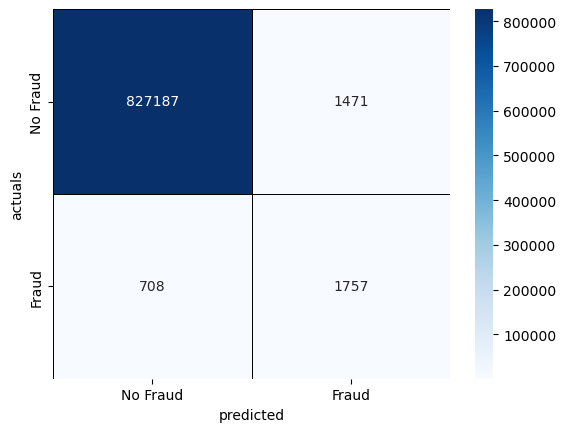

In [24]:
sns.heatmap(conf_mat,annot=True,fmt='d',cmap='Blues',linewidths=0.5,linecolor='Black')
plt.xticks(np.arange(2)+.5,['No Fraud','Fraud'])
plt.yticks(np.arange(2)+.5,['No Fraud','Fraud'])
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

In [25]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828658
           1       0.54      0.71      0.62      2465

    accuracy                           1.00    831123
   macro avg       0.77      0.86      0.81    831123
weighted avg       1.00      1.00      1.00    831123



above classification report says that, Logistic Regression model giving 62% of f1-score, 71% of recall and 54% of precision score which is not bad   

### 2. Using Decision Tree Model

In [26]:
dt = DecisionTreeClassifier()

In [27]:
dt.fit(X_train,y_train)

DecisionTreeClassifier()

we trained the model using Decision Tree Classifier

In [28]:
dt_predicted = dt.predict(X_test)

In [29]:
dt_con_mat = confusion_matrix(y_test,dt_predicted)
dt_con_mat

array([[828400,    258],
       [   259,   2206]], dtype=int64)

Text(50.722222222222214, 0.5, 'actuals')

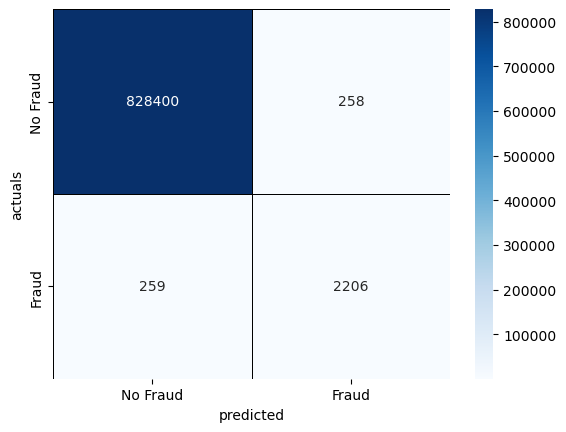

In [30]:
sns.heatmap(dt_con_mat,annot=True,fmt='d',cmap='Blues',linewidths=0.5,linecolor='Black')
plt.xticks(np.arange(2)+.5,['No Fraud','Fraud'])
plt.yticks(np.arange(2)+.5,['No Fraud','Fraud'])
plt.xlabel("predicted")
plt.ylabel("actuals")

In [31]:
print(classification_report(y_test,dt_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828658
           1       0.90      0.89      0.90      2465

    accuracy                           1.00    831123
   macro avg       0.95      0.95      0.95    831123
weighted avg       1.00      1.00      1.00    831123



here we have created classification report of Decison Tree model giving f1-score as 90%, recall as 89% and precision score 90% 

## Conclusion 

so by comparing these two models, we can say that Decision Tree model gives better performance in predicting fraudulent transactions for a 
financial company 